In [2]:
'''
Training Data is a N*T*n tensor, N is the number of samples, T is the interval,
n is number of neurons.
Training Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the
output dimension, which is the position of last time point.
Testing Data is a N'*T*n tensor.
Testing label is a N*1*1 tensor.
E.g.,
TrainingData = create_subsequences(np.transpose(X, TimeInterval))
TrainingLabel = Y[TimeInterval-1:].reshape(-1,1)
X is dFF, Y is corresponding position.
'''

"\nTraining Data is a N*T*n tensor, N is the number of samples, T is the interval,\nn is number of neurons.\nTraining Data is a N*1*1 tensor, N is the number of samples, 1*1 represents the\noutput dimension, which is the position of last time point.\nTesting Data is a N'*T*n tensor.\nTesting label is a N*1*1 tensor.\nE.g.,\nTrainingData = create_subsequences(np.transpose(X, TimeInterval))\nTrainingLabel = Y[TimeInterval-1:].reshape(-1,1)\nX is dFF, Y is corresponding position.\n"

In [1]:
import torch, os, glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
import scipy, pandas as pd, random
from sklearn.preprocessing import MinMaxScaler

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim = 256, output_dim = 1, 
        num_layers = 2):
        super(LSTMModel, self).__init__()
        # Initialize the LSTM, Hidden Layer, and Output Layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                dropout = 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        
        return out

def create_subsequences(time_series, subsequence_length=20):
    num_subsequences = len(time_series) - subsequence_length + 1
    subsequences = [time_series[i:i+subsequence_length] for i in range(num_subsequences)]
    return np.array(subsequences)

class CreateTimeSeriesData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [10]:
# import raw data
with open("Z:\dcts_com_opto_inference.p", "rb") as fp: #unpickle
        dcts = pickle.load(fp)
# can be different depending on model version
conddf = pd.read_csv(r"Z:\condition_df\conddf_neural_com_inference.csv", index_col=None)

In [3]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["xtick.major.size"] = 8
mpl.rcParams["ytick.major.size"] = 8
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
savedst = r'C:\Users\Han\Box\neuro_phd_stuff\han_2023-\thesis_proposal'
def run_inference_optoep_for_vis(conddf, dd, dcts,
            savepth = r'Z:\\models_lstm_all_cells', savedst = savedst):    
    """
    run inference on opto ep and get error
    """
    savepth = glob.glob(os.path.join(savepth, f'model_dd{dd:02d}*'), recursive=True)[0]
    if os.path.exists(savepth):
        day=conddf.days.values[dd]
        animal = conddf.animals.values[dd]
        params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
        print(params_pth)
        fall = scipy.io.loadmat(params_pth, variable_names=['dFF', 'forwardvel', 'ybinned', 'iscell',
                                    'trialnum', 'bordercells', 'changeRewLoc', 'licks'])
        inactive = dcts[dd]['inactive']
        changeRewLoc = np.hstack(fall['changeRewLoc']) 
        eptest = conddf.optoep.values[dd]
        eps = np.where(changeRewLoc>0)[0]
        rewlocs = changeRewLoc[eps]
        eps = np.append(eps, len(changeRewLoc)) 
        if conddf.optoep.values[dd]<2: 
            eptest = random.randint(2,3)   
            if len(eps)<4: eptest = 2 # if no 3 epochs
        trialnum = np.hstack(fall['trialnum'])
        comp = [int(savepth[-17:-16]), int(savepth[-15:-14])] # eps to compare    
        other_ep = [xx for xx in range(len(eps)-1) if xx not in comp]
        # filter iscell
        dff = fall['dFF'][:,(fall['iscell'][:,0].astype(bool)) & (~fall['bordercells'][0].astype(bool))]
        # remove nans
        dff[:, sum(np.isnan(dff))>0] = 0
        dff_per_ep = [dff[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
        trialnum_per_ep = [trialnum[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
        # get a subset of trials
        dff_per_ep_trials = [dff_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        dff_per_ep_trials_test = [dff_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        position = fall['ybinned'][0]
        position_per_ep = [position[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
        # get a subset of trials
        position_per_ep_trials = [position_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        position_per_ep_trials_test = [position_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        # licks
        licks = fall['licks'][0]
        licks_per_ep = [licks[eps[xx]:eps[xx+1]] for xx in range(len(eps)-1)]
        # get a subset of trials
        licks_per_ep_trials = [licks_per_ep[ii][((trialnum_per_ep[ii]>2) & (trialnum_per_ep[ii]<=10)) | (trialnum_per_ep[ii]>15)] for ii in range(len(eps)-1)]
        licks_per_ep_trials_test = [licks_per_ep[ii][(trialnum_per_ep[ii]>10) & (trialnum_per_ep[ii]<16)] for ii in range(len(eps)-1)]
        #prepare variables 
        TimeInterval = 15 # frames
        # run inference on opto epoch
        test = dff_per_ep_trials[comp[1]]
        if len(test)>0: # check if enough trials exists.
            test_pos = position_per_ep_trials[comp[1]]
            lick = licks_per_ep_trials[comp[1]]
            TestLabel = test_pos[TimeInterval-1:].reshape(-1,1)
            TestData = create_subsequences(test,TimeInterval)
            batch_size = 128
            input_size = TestData.shape[-1] # number of cells
            output_size = 1        
            
            Test_dataset = CreateTimeSeriesData(TestData, TestLabel)
            Test_loader = DataLoader(dataset=Test_dataset, batch_size=batch_size,
                        shuffle=False, drop_last = True)        

            # load existing model                
            print(savepth)
            model = LSTMModel(input_size, output_dim = output_size)
            model.load_state_dict(torch.load(savepth))
            device = torch.device("cpu")
            print(device)
            model = model.to(device)
            criterion = nn.MSELoss()  # For regression tasks
            # criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, 
                        weight_decay = 1e-9)
            predict = []
            val_loss = 0
            for inputs, targets in Test_loader:
                # Forward pass
                inputs, targets = inputs.to(device).float(), targets.to(device).float()
                outputs = model(inputs)
                predict.append(outputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
            print('Validation Loss: {:.4f}'.format(val_loss/len(Test_loader)))
            predict = np.concatenate([xx.cpu().detach().numpy() for xx in predict])
            predict_vis = np.squeeze(np.array(pd.DataFrame(predict).interpolate().rolling(50).mean().interpolate().values))
            pos = test_pos
            fig, axes = plt.subplots(1,3, figsize=(20,7))
            # 5625= 3 min
            axes[0].plot(pos[:5625], label='True position')
            axes[1].plot(predict_vis[:5625],color='darkorange', label='Predicted position')
            axes[2].plot(pos[:5625],label='True position')
            axes[2].plot(predict_vis[:5625],color='darkorange', label='Predicted position')
            axes[0].scatter(np.where(lick[:5625]>0)[0], pos[:5625][np.where(lick[:5625]>0)[0]], s=20, color='k',
                        label='Lick')
            axes[0].set_xlabel("Time (s)")
            axes[0].set_ylabel("Position (cm)")
            axes[0].legend()
            axes[1].legend()
            axes[2].legend()
            fig.suptitle(f'Animal: {animal}, Day: {day}, optoep: {conddf.optoep.values[dd]}')
            plt.savefig(os.path.join(savedst,rf'{animal}_{day}_prediction.svg'), bbox_inches='tight')
            plt.close(fig)
            # Compute the MAE and MSE on a test set            
            if pos.shape[0]>predict.shape[0]:
                pos = pos[:predict.shape[0]]
            mae = mean_absolute_error(pos, predict)
            mse = mean_squared_error(pos, predict)
            print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")
            return dd,[mse,mae]

In [4]:
# make models for all animals/days
from sklearn.metrics import mean_absolute_error, mean_squared_error
errors = []
dds = np.arange(0,len(conddf))
dds_run = [] # grab the days that meet criteria
for dd in dds: #len(conddf)
    # if conddf.in_type.values[dd]=='vip':
    try:
        dd,err = run_inference_optoep_for_vis(conddf,dd,dcts)
        errors.append(err)
        dds_run.append(dd)
    except Exception as e:
        print(e)

Y:\analysis\fmats\e218\days\e218_day020_plane0_Fall.mat


Z:\\models_lstm_all_cells\model_dd00_epcompare0-1_e218_day20.pt
cpu
Validation Loss: 2366.1285
(18732,)
(18688, 1)
MAE: 37.0267, MSE: 2574.8524
Y:\analysis\fmats\e218\days\e218_day021_plane0_Fall.mat
Z:\\models_lstm_all_cells\model_dd01_epcompare1-2_e218_day21.pt
cpu
Validation Loss: 2523.3980
(4377,)
(4352, 1)
MAE: 39.8752, MSE: 2595.2507
Y:\analysis\fmats\e218\days\e218_day022_plane0_Fall.mat
Z:\\models_lstm_all_cells\model_dd02_epcompare0-1_e218_day22.pt
cpu
Validation Loss: 3175.4791
(11740,)
(11648, 1)
MAE: 46.6496, MSE: 3473.2386
Y:\analysis\fmats\e218\days\e218_day023_plane0_Fall.mat
Z:\\models_lstm_all_cells\model_dd03_epcompare1-2_e218_day23.pt
cpu
Validation Loss: 1577.1446
(12657,)
(12544, 1)
MAE: 31.1673, MSE: 1829.1490
Y:\analysis\fmats\e218\days\e218_day035_plane0_Fall.mat
Z:\\models_lstm_all_cells\model_dd04_epcompare1-2_e218_day35.pt
cpu
Validation Loss: 5596.9550
(17294,)
(17280, 1)
MAE: 55.5892, MSE: 5434.6853
Y:\analysis\fmats\e218\days\e218_day044_plane0_Fall.mat
Z:

    mean_squared_error  mean_absolute_error animals in_type  day    condition
0          2574.852432            37.026738    e218     vip   20   vip_ledoff
1          2595.250724            39.875193    e218     vip   21   vip_ledoff
2          3473.238557            46.649565    e218     vip   22   vip_ledoff
3          1829.148976            31.167319    e218     vip   23   vip_ledoff
4          5434.685349            55.589156    e218     vip   35    vip_ledon
..                 ...                  ...     ...     ...  ...          ...
80         1936.310168            29.208125    e190    ctrl   35  ctrl_ledoff
81         1476.878888            28.597079    e190    ctrl   40   ctrl_ledon
82         2573.446412            34.876970    e190    ctrl   41  ctrl_ledoff
83         3685.099271            47.080586    e190    ctrl   42  ctrl_ledoff
84         4540.650795            50.247083    e190    ctrl   45   ctrl_ledon

[78 rows x 6 columns]


TtestResult(statistic=-6.360931832400501, pvalue=0.02383482095213948, df=2)

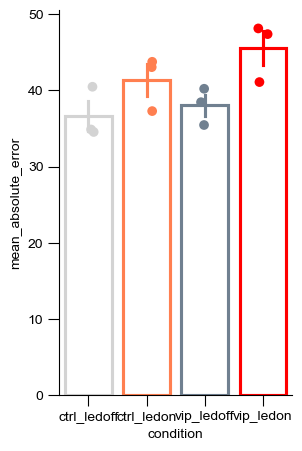

In [55]:
# quantify error
errors_arr = np.array(errors)
dds = np.array(dds_run)
df = pd.DataFrame()

df['mean_squared_error'] = errors_arr[:,0]
df['mean_absolute_error'] = errors_arr[:,1]
conddf_ = conddf.iloc[dds]
conddf_.reset_index(drop=True)
df['animals'] = conddf_.animals.values
df['in_type'] = conddf_.in_type.values
df['day'] = conddf_.days.values
# print(len(dds))
# print(len(errors))
# print(len(conddf_))
condition = []
for ii,ep in enumerate(conddf_.optoep.values):
    if conddf_.in_type.values[ii]=='vip' and ep<2:
        condition.append('vip_ledoff')
    elif conddf_.in_type.values[ii]=='vip' and ep>=2:
        condition.append('vip_ledon')
    elif conddf_.in_type.values[ii]!='vip' and ep<2:
        condition.append('ctrl_ledoff')
    elif conddf_.in_type.values[ii]!='vip' and ep>=2:
        condition.append('ctrl_ledon')
df['condition'] = condition
df = df[(df.animals!='e189') & (df.animals!='e186')]
df.to_csv(r'C:\Users\Han\Desktop\test.csv')
print(df)
df = df.groupby(['animals', 'condition']).quantile(.7,numeric_only=True)

import seaborn as sns
plt.figure(figsize=(3,5))
ax = sns.barplot(x = 'condition', y = 'mean_absolute_error', hue = 'condition', data=df,
        fill=False, errorbar='se',
        palette={'vip_ledoff': "slategray", 'vip_ledon': "red",
                'ctrl_ledoff': "lightgray", 'ctrl_ledon': "coral"})
ax = sns.stripplot(x = 'condition', y = 'mean_absolute_error', hue = 'condition', data=df,
        palette={'vip_ledoff': "slategray", 'vip_ledon': "red",
                'ctrl_ledoff': "lightgray", 'ctrl_ledon': "coral"},s=7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(os.path.join(savedst, 'allcells_mean_abs_error_lstm.svg'), bbox_inches='tight')

scipy.stats.ttest_rel(df.loc[(df.index.get_level_values('condition') == 'vip_ledoff'), 'mean_absolute_error'].values,
    df.loc[(df.index.get_level_values('condition') == 'vip_ledon'), 'mean_absolute_error'].values)
# scipy.stats.ranksums(df.loc[(df.index.get_level_values('condition') == 'ctrl_ledon'), 'mean_absolute_error'].values,
#     df.loc[(df.index.get_level_values('condition') == 'vip_ledon'), 'mean_absolute_error'].values)

# print(scipy.stats.ttest_ind(df.loc[df.condition == 'ctrl_ledon', 'mean_absolute_error'].values,
#     df.loc[df.condition == 'vip_ledon', 'mean_absolute_error'].values))
